[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/simframe/HEAD?labpath=examples%2Fexample_double_pendulum.ipynb)

# Example: Double Pendulum

In this example we are going to simulate the [double pendulum](https://en.wikipedia.org/wiki/Double_pendulum) with an adaptive integration scheme.

The double pendulum is two pendulums attached to each other with masses $m_1$ and $m_2$ and lengths $l_1$ and $l_2$. It is fully defined by two angles $\theta_1$ and $\theta_2$ and two angular velocities $\omega_1=\dot{\theta}_1$ and $\omega_2=\dot{\theta}_2$. We are therefore going to simulate the evolution of the state vector

$\Large \vec{Y} = \begin{pmatrix}\theta_1 \\ \theta_2 \\ \omega_1 \\ \omega_2\end{pmatrix}$

In [1]:
# Mass and length of 1st pendulum
mass1 = 1.
length1 = 1.
# Mass and length of 2nd pendulum
mass2 = 1.
length2 = 2.

We are going to store the quantities of the two pendulums in separate groups.

In [2]:
from simframe import Frame

In [3]:
sim = Frame(description="Double Pendulum")

In [4]:
sim.addgroup("p1", description="Pendulum 1")
sim.addgroup("p2", description="Pendulum 2")

In [5]:
sim.p1.addfield("m", mass1, description="Mass", constant=True)
sim.p1.addfield("l", length1, description="Length", constant = True)
sim.p1.addfield("r", [0., 0.], description="Cartesian position vector")

sim.p2.addfield("m", mass2, description="Mass", constant=True)
sim.p2.addfield("l", length2, description="Length", constant = True)
sim.p2.addfield("r", [0., 0.], description="Cartesian position vector")

And we create a field for the state vector and initialize it with some values for the angles.

In [6]:
import numpy as np

In [7]:
Y0 = [
    0.25*np.pi, # theta 1
    0.15*np.pi, # theta 2
    0.,         # omega 1
    0.          # omega 2
]

In [8]:
sim.addfield("Y", Y0, description="State vector")

For convenience we store the cartesian coordinates of the masses in their respective groups. Therefore we need functions that convert the angles into cartesian coordinates and assign it to their updaters.

$\Large \vec{r}_1 = \begin{pmatrix}l_1\sin\theta_1 \\ -l_1\cos\theta_1 \end{pmatrix}$

$\Large \vec{r}_2 = \begin{pmatrix} l_1\sin\theta_1+l_2\sin\theta_2 \\ -l_1\cos\theta_1-l_2\cos\theta_2 \end{pmatrix}$

In [9]:
def r1(sim):
    theta1 = sim.Y[0]
    theta2 = sim.Y[1]
    return sim.p1.l*np.sin(theta1), -sim.p1.l*np.cos(theta1)

def r2(sim):
    theta1 = sim.Y[0]
    theta2 = sim.Y[1]
    return sim.p1.l*np.sin(theta1)+sim.p2.l*np.sin(theta2), -sim.p1.l*np.cos(theta1)-sim.p2.l*np.cos(theta2)

In [10]:
sim.p1.r.updater = r1
sim.p2.r.updater = r2

Now we have to assign updaters to the group and the simulation object.

In [11]:
sim.p1.updater = ["r"]
sim.p2.updater = ["r"]
sim.updater = ["p1", "p2"]

After updating the simulation frame, the cartesian coordinates are stored in the pendulum groups.

In [12]:
sim.update()

In [13]:
print("x1 = {:4.1f}, y1 = {:4.1f}\nx2 = {:4.1f}, y2 = {:4.1f}".format(sim.p1.r[0], sim.p1.r[1], sim.p2.r[0], sim.p2.r[1]))

x1 =  0.7, y1 = -0.7
x2 =  1.6, y2 = -2.5


Here is a plot to visualize the problem.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["figure.dpi"] = 150.

In [15]:
def plot_system(sim):
    fig, ax = plt.subplots(figsize=(6.4, 6.4))
    ax.set_aspect(1.)
    ax.axis("off")
    
    # Maximum radius the double pendulum can have
    L = sim.p1.l + sim.p2.l
    # Radius of a ball in the plot
    r = 0.05*L
    
    p1 = patches.Circle(sim.p1.r, r, linewidth=1, edgecolor="#000000", facecolor="C1")
    ax.add_patch(p1)
    p2 = patches.Circle(sim.p2.r, r, linewidth=1, edgecolor="#000000", facecolor="C9")
    ax.add_patch(p2)
    circ = patches.Circle((0, 0), sim.p1.l, linewidth=1, edgecolor="C1", facecolor="None", zorder=-1, ls="--")
    ax.add_patch(circ)
    origin = patches.Circle((0, 0), 0.5*r, linewidth=1, edgecolor=None, facecolor="C3")
    ax.add_patch(origin)
    
    ax.plot([0, sim.p1.r[0]], [0, sim.p1.r[1]], zorder=-1, lw=1, c="#000000")
    ax.plot([sim.p2.r[0], sim.p1.r[0]], [sim.p2.r[1], sim.p1.r[1]], zorder=-1, lw=1, c="#000000")
    
    ax.set_xlim(-1.1*L, 1.1*L)
    ax.set_ylim(-1.1*L, 1.1*L)
    
    fig.tight_layout()
    
    return fig, ax

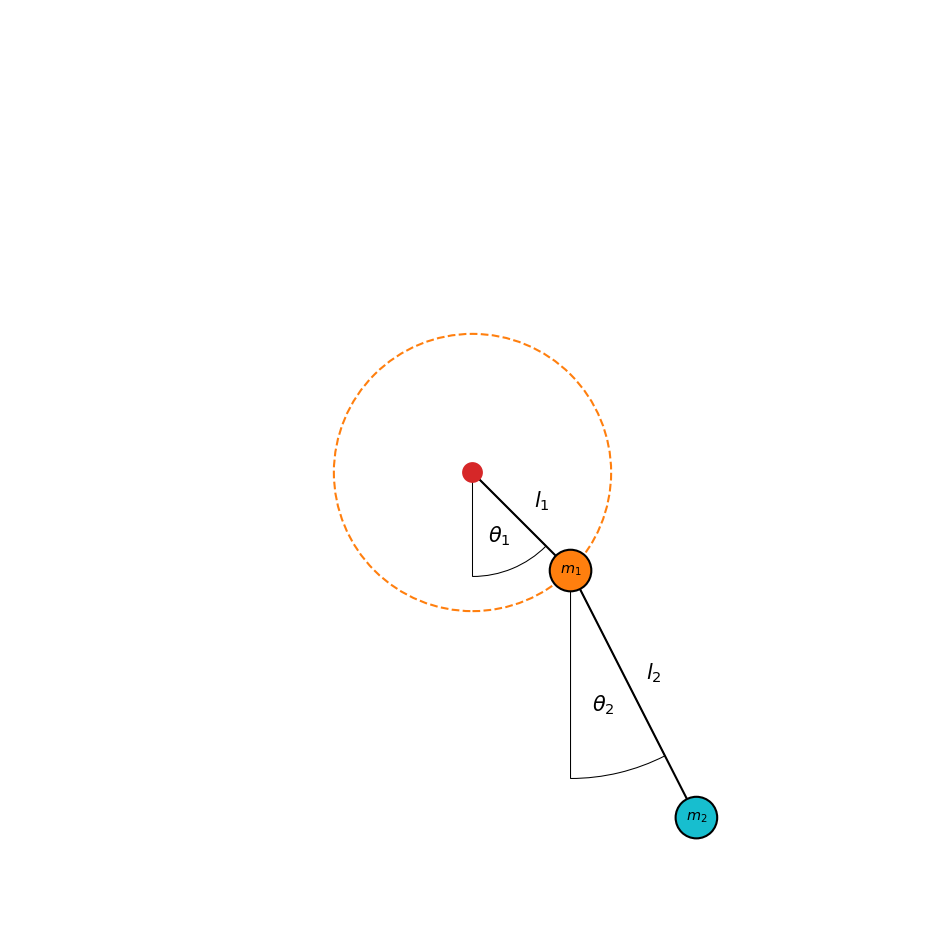

In [16]:
fig, ax = plot_system(sim)

L = sim.p1.l + sim.p2.l
r = 0.05*L

theta1 = patches.Wedge([0, 0], 0.75*sim.p1.l, -90, sim.Y[0]/np.pi*180.-90, linewidth=0.5, edgecolor="#000000", facecolor="None", zorder=-1)
ax.add_patch(theta1)
theta2 = patches.Wedge([sim.p1.r[0], sim.p1.r[1]], 0.75*sim.p2.l, -90, sim.Y[1]/np.pi*180.-90, linewidth=0.5, edgecolor="#000000", facecolor="None", zorder=-1)
ax.add_patch(theta2)
    
ax.text(sim.p1.r[0], sim.p1.r[1], "$m_1$", ha="center", va="center", fontsize="x-small")
ax.text(sim.p2.r[0], sim.p2.r[1], "$m_2$", ha="center", va="center", fontsize="x-small")
ax.text(0.5*sim.p1.r[0]+r, 0.5*sim.p1.r[1]+r, "$l_1$", ha="center", va="center")
ax.text(0.5*(sim.p1.r[0]+sim.p2.r[0])+r, 0.5*(sim.p1.r[1]+sim.p2.r[1])+r, "$l_2$", ha="center", va="center") 
    
ax.text(0.5*sim.p1.l*np.sin(0.5*sim.Y[0]), -0.5*sim.p1.l*np.cos(0.5*sim.Y[0]), r"$\theta_1$", ha="center", va="center")
ax.text(0.5*sim.p2.l*np.sin(0.5*sim.Y[1])+sim.p1.r[0], -0.5*sim.p2.l*np.cos(0.5*sim.Y[1])+sim.p1.r[1], r"$\theta_2$", ha="center", va="center")

plt.show()

We now need the equations of motion of the problem. We are going to use [Lagrangian mechanics](https://en.wikipedia.org/wiki/Lagrangian_mechanics) to get the derivates of $\omega_1$ and $\omega_2$.

The kinetic energy of the system is given by

$\Large T = \frac{1}{2}m_1v_1^2 + \frac{1}{2}m_2v_2^2 = \frac{1}{2}m_1\left(\dot{x}_1^2+\dot{y}_1^2\right) + \frac{1}{2}m_2\left(\dot{x}_2^2+\dot{y}_2^2\right)$

From the definition of the cartesian coordinates above we get

$\Large \dot{x}_1 = l_1\omega_1\cos\theta_1, \quad \dot{y}_1 = l_1\omega_1\sin\theta_1$

$\Large \dot{x}_2 = l_1\omega_1\cos\theta_1+l_2\omega_2\cos\theta_2, \quad \dot{y}_2 = l_1\omega_1\sin\theta_1+l_2\omega_2\sin\theta_2$

which yields

$\Large T = \frac{1}{2}m_1l_1^2\omega_1^2 + \frac{1}{2}m_2\left(l_1^2\omega_1^2+l_2^2\omega_2^2+2l_1l_2\omega_1\omega_2\cos\left(\theta_1-\theta_2\right)\right)$,

where $\cos\theta_1\cos\theta_2 + \sin\theta_1\sin\theta_2 = \cos\left(\theta_1-\theta_2\right)$ was used.

The potential energy of the system is given by

$\Large V = gm_1y_1 + gm_2y_2 = -g\left(m_1+m_2\right)l_1\cos\theta_1 - gm_2l_2\cos\theta_2$

with the gravitational acceleration $g$.

Therefore, the Langrangian is given by

$\Large \mathcal{L} = T-V = \frac{1}{2}m_1l_1^2\omega_1^2 + \frac{1}{2}m_2\left(l_1^2\omega_1^2+l_2^2\omega_2^2+2l_1l_2\omega_1\omega_2\cos\left(\theta_1-\theta_2\right)\right) + g\left(m_1+m_2\right)l_1\cos\theta_1 + gm_2l_2\cos\theta_2$

The canonical momenta conjugate to $\theta_i$ are given by

$\Large p_{\theta_i} = \frac{\partial \mathcal{L}}{\partial \dot{\theta}_i}$

These are

$\Large p_{\theta_1} = \frac{\partial \mathcal{L}}{\partial \omega_1} = \left(m_1+m_2\right)l_1^2\omega_1 + m_2l_1l_2\omega_1\cos\left(\theta_1-\theta_2\right)$

$\Large p_{\theta_2} = \frac{\partial \mathcal{L}}{\partial \omega_2} = m_2l_2^2\omega_2 + m_2l_1l_2\omega_1\cos\left(\theta_1-\theta_2\right)$

The [Euler-Lagrange equations of motion](https://en.wikipedia.org/wiki/Euler%E2%80%93Lagrange_equation) are given by

$\Large \frac{\mathrm{d}}{\mathrm{d}t}\left( \frac{\partial \mathcal{L}}{\partial \omega_i} \right) - \frac{\partial \mathcal{L}}{\partial \theta_i} = 0$,

which are a set of two coupled differential equations in the case of the double pendulum, that can be simplified to

$\Large \dot{\omega}_1 + \frac{m_2}{m_1+m_2}\frac{l_2}{l_1}\cos\left(\theta_1-\theta_2\right)\dot{\omega}_2 = -\frac{m_2}{m_1+m_2}\frac{l_2}{l_1}\omega_2^2\sin\left(\theta_1-\theta_2\right)-\frac{g}{l_1}\sin\theta_1$

$\Large \frac{l_1}{l_2}\cos\left(\theta_1-\theta_2\right)\dot{\omega}_1 + \dot{\omega}_2 = \frac{l_1}{l_2}\omega_1^2\sin\left(\theta_1-\theta_2\right) - \frac{g}{l_2}\sin\theta_1$

This system of equations can be written as a matrix equation

$\Large \mathbb{A} \cdot \begin{pmatrix} \dot{\omega}_1 \\ \dot{\omega}_2 \end{pmatrix} = \begin{pmatrix} 1 & \alpha_1 \\ \alpha_2 & 1 \end{pmatrix} \cdot \begin{pmatrix} \dot{\omega}_1 \\ \dot{\omega}_2 \end{pmatrix} = \begin{pmatrix} \beta_1 \\ \beta_2 \end{pmatrix}$.

This matrix equation can be solved for $\dot{\omega}_1$ and $\dot{\omega}_2$ via

$\Large \begin{pmatrix} \dot{\omega}_1 \\ \dot{\omega}_2 \end{pmatrix} = \mathbb{A}^{-1} \cdot \begin{pmatrix} \beta_1 \\ \beta_2 \end{pmatrix}$

Since the determinant of $\mathbb{A}$ always differs from zero

$\Large \det\mathbb{A} = 1-\alpha_1\alpha_2 = 1- \frac{m_2}{m_1+m_2}\cos^2\left(\theta_1-\theta_2\right) \neq 0$

the matrix itself can always be inverted.

$\Large \mathbb{A}^{-1} = \frac{1}{\det\mathbb{A}} \begin{pmatrix} 1 & -\alpha_1 \\ -\alpha_2 & 1 \end{pmatrix}$

Therefore, the equations of motion for $\omega_1$ and $\omega_2$ are given by

$\Large \dot{\omega}_1 = \frac{\beta_1-\alpha_1\beta_2}{1-\alpha_1\alpha_2}$

$\Large \dot{\omega}_2 = \frac{\beta_2-\alpha_2\beta_1}{1-\alpha_1\alpha_2}$

We can now write a function that returns the derivate of our state vector $\vec{Y}$.

In [17]:
# Gravitational acceleration in m/s²
g = 9.81

In [18]:
def dYdt(sim, x, Y):
    theta1 = Y[0]
    theta2 = Y[1]
    omega1 = Y[2]
    omega2 = Y[3]
    
    # Derivatives of the angles
    dtheta1 = omega1
    dtheta2 = omega2
    
    beta1 = -sim.p2.m/(sim.p1.m+sim.p2.m)*sim.p2.l/sim.p1.l*omega2**2*np.sin(theta1-theta2) - g/sim.p1.l*np.sin(theta1)
    beta2 = sim.p1.l/sim.p2.l*omega1**2*np.sin(theta1-theta2) - g/sim.p2.l*np.sin(theta2)
    
    alpha1 = sim.p2.m/(sim.p1.m+sim.p2.m)*sim.p2.l/sim.p1.l*np.cos(theta1-theta2)
    alpha2 = sim.p1.l/sim.p2.l*np.cos(theta1-theta2)
    detA = 1. - alpha1*alpha2
    
    # Derivatives of the angular velocities
    domega1 = (beta1-alpha1*beta2)/detA
    domega2 = (beta2-alpha2*beta1)/detA
    
    return np.array([dtheta1, dtheta2, domega1, domega2])

This function has to be assigned to the differentiator of the state vector.

In [19]:
sim.Y.differentiator = dYdt

Now we can set up the integration variable.

In [20]:
sim.addintegrationvariable("t", 0., description="Time")

Since we are going to use an adaptive scheme, the timestep we want to use is the timestep suggested by the scheme.

In [21]:
def dt(sim):
    return sim.t.suggested

In [22]:
sim.t.updater = dt

We have to suggest a timestep initially for the scheme to work.

In [23]:
sim.t.suggest(1.)

We want to create an animation later from the simulation result. Therefore, we define the snapshots in a way that they match our desired frame rate. For this we define the frames per second and the maximum simulation time.

In [24]:
fps = 30.
t_max = 30.

In [25]:
sim.t.snapshots = np.arange(0., t_max, 1./fps)

Next we can set up the integrator.

In [26]:
from simframe import Integrator
from simframe import Instruction
from simframe import schemes

In [27]:
sim.integrator = Integrator(sim.t)

We have one integration instruction that is integrating our state vector with the 5th-order adaptive Cash-Karp scheme. We also lower the value of $\epsilon$, which is the maximum accepted relative error of the integration scheme.

In [28]:
sim.integrator.instructions = [
    Instruction(schemes.expl_5_cash_karp_adptv, sim.Y, controller={"eps": 0.001})
]

We do not want to write output files. Instead we use the namespace writer to store the data in the simulation frame itself.

In [29]:
from simframe import writers

In [30]:
sim.writer = writers.namespacewriter()

Since we are having many snapshots we do not want the writer to write on screen.

In [31]:
sim.writer.verbosity = 0

For a more interesting example we change the initial conditions.

In [32]:
Y0 = [
    0.5*np.pi,  # theta 1
    1.0*np.pi,  # theta 2
    0.,         # omega 1
    0.          # omega 2
]

In [33]:
sim.Y[:] = Y0

In [34]:
sim.update()

We can now plot the initial state.

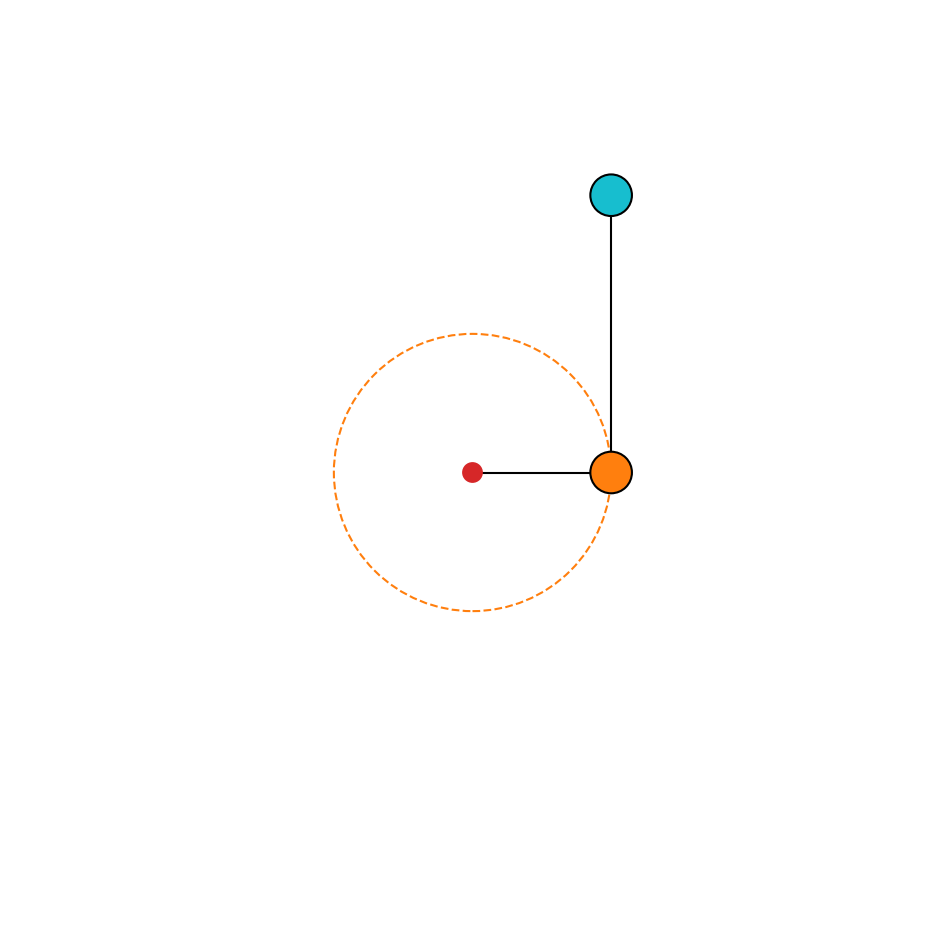

In [35]:
fig, ax = plot_system(sim)

We are now ready to run the simulation.

In [36]:
sim.run()

Execution time: 0:00:05


After the simulation is finished we can read the data

In [37]:
data = sim.writer.read.all()

and plot the trajectory of the second pendulum.

In [38]:
def plot_trajectories(dataset):
    fig, ax = plt.subplots(figsize=(6.4, 6.4))
    ax.set_aspect(1.)
    ax.axis("off")
    
    L = dataset[0].p1.l[0] + dataset[0].p2.l[0]
    r = 0.05*L

    origin = patches.Circle((0, 0), 0.5*r, linewidth=1, edgecolor=None, facecolor="C3")
    ax.add_patch(origin)
    
    for d in dataset:
        p, = ax.plot(d.p2.r[:, 0], d.p2.r[:, 1], lw=1, zorder=-1)
        ax.plot(d.p2.r[-1, 0], d.p2.r[-1, 1], "o", c=p.get_color(), markeredgecolor="#000000")
        ax.plot(d.p2.r[0, 0], d.p2.r[0, 1], "o", c="#000000")

    ax.set_xlim(-1.1*L, 1.1*L)
    ax.set_ylim(-1.1*L, 1.1*L)
    
    fig.tight_layout()

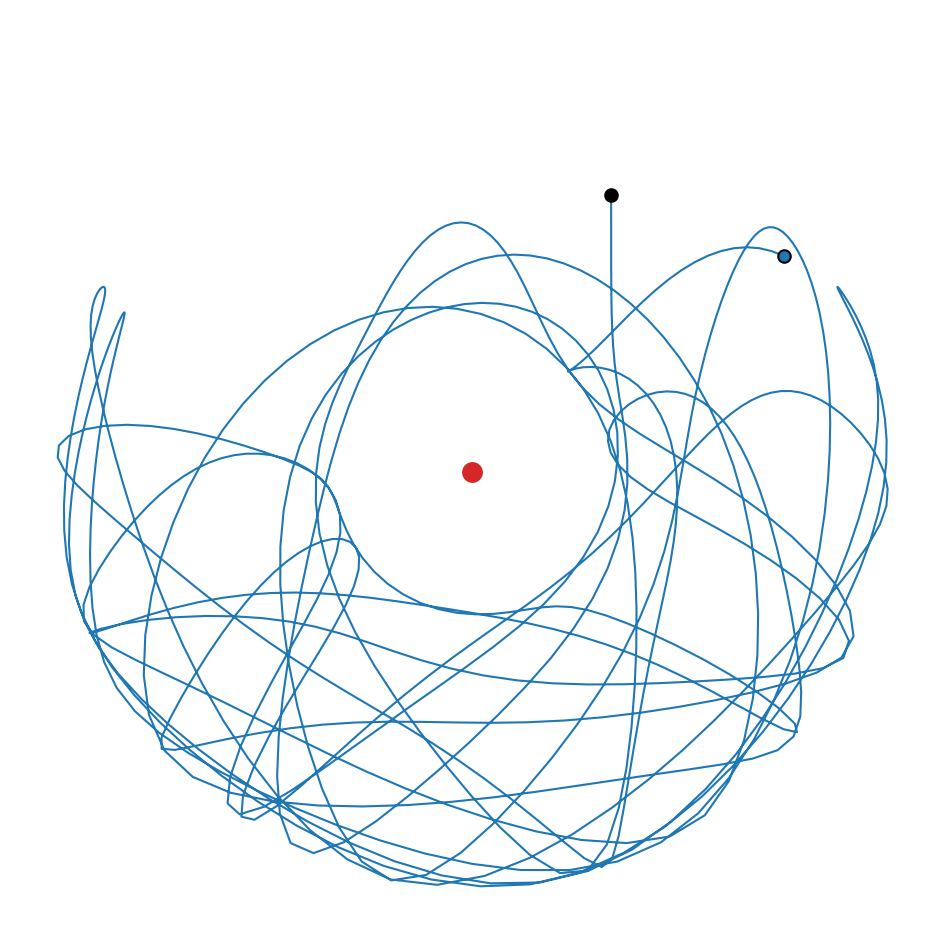

In [39]:
plot_trajectories([data])

We should also check for energy conservation to see if the integration scheme was accurate enough.

In [40]:
def plot_energy_error(data):
    vx1 = data.Y[:, 2]*data.p1.l*np.cos(data.Y[:, 0])
    vy1 = data.Y[:, 2]*data.p1.l*np.sin(data.Y[:, 0])
    vx2 = vx1 + data.Y[:, 3]*data.p2.l*np.cos(data.Y[:, 1])
    vy2 = vy1 + data.Y[:, 3]*data.p2.l*np.sin(data.Y[:, 1])
    v1 = np.sqrt(vx1**2+vy1**2)
    v2 = np.sqrt(vx2**2+vy2**2)
    T = 0.5*(data.p1.m*v1**2 + data.p2.m*v2**2)
    V = g*(data.p1.m*data.p1.r[:, 1] + data.p2.m*data.p2.r[:, 1])
    E = T+V
    fig, ax = plt.subplots()
    ax.semilogy(data.t, np.abs(E-E[0])/E[0])
    ax.set_xlim(data.t[0], data.t[-1])
    ax.set_xlabel("Time")
    ax.set_ylabel("Relative Energy Error")
    fig.tight_layout()

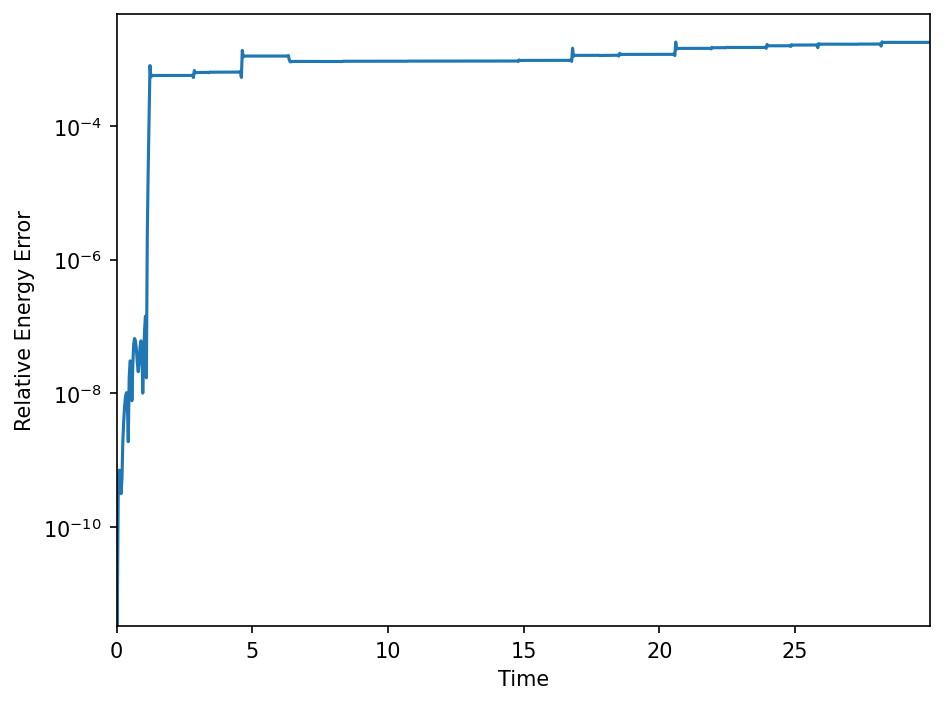

In [41]:
plot_energy_error(data)

The maximum relative energy error that we have in our simulation is less that $0.1\%$.

**Note**: we could have also used the leapfrog integrator as in the example of the coupled oscillators for better energy conservation.

We can also create an animation of the entire simulation.

In [42]:
def plot_animation(data):
    fig, ax = plt.subplots(figsize=(6.4, 6.4))
    ax.set_aspect(1.)
    ax.axis("off")
    
    L = sim.p1.l + sim.p2.l
    r = 0.05*L
    
    p1 = patches.Circle(data.p1.r[0], r, linewidth=1, edgecolor="#000000", facecolor="C1")
    ax.add_patch(p1)
    p2 = patches.Circle(data.p2.r[0], r, linewidth=1, edgecolor="#000000", facecolor="C9")
    ax.add_patch(p2)
    circ = patches.Circle((0, 0), data.p1.l[0], linewidth=1, edgecolor="C1", facecolor="None", zorder=-1, ls="--", lw=0.5)
    ax.add_patch(circ)
    origin = patches.Circle((0, 0), 0.5*r, linewidth=1, edgecolor=None, facecolor="C3")
    ax.add_patch(origin)
    
    l1, = ax.plot([0, data.p1.r[0, 0]], [0, data.p1.r[0, 1]], zorder=-1, lw=1, c="#000000")
    l2, = ax.plot([data.p2.r[0, 0], data.p1.r[0, 0]], [data.p2.r[0, 1], data.p1.r[0, 1]], zorder=-1, lw=1, c="#000000")
    plot2, = ax.plot(data.p2.r[0, 0], data.p2.r[0, 1], c="C9", lw=1., alpha=.33)
    
    ax.set_xlim(-1.1*L, 1.1*L)
    ax.set_ylim(-1.1*L, 1.1*L)
    
    fig.tight_layout()
    
    return fig, ax, p1, p2, l1, l2, plot2

In [43]:
def animate(i):
    p1.center = (data.p1.r[i])
    p2.center = (data.p2.r[i])
    l1.set_data([0, data.p1.r[i, 0]], [0, data.p1.r[i, 1]])
    l2.set_data([data.p2.r[i, 0], data.p1.r[i, 0]], [data.p2.r[i, 1], data.p1.r[i, 1]])
    plot2.set_data(data.p2.r[:i, 0], data.p2.r[:i, 1])
    plt.show()
    return p1, p2, l1, l2, plot2

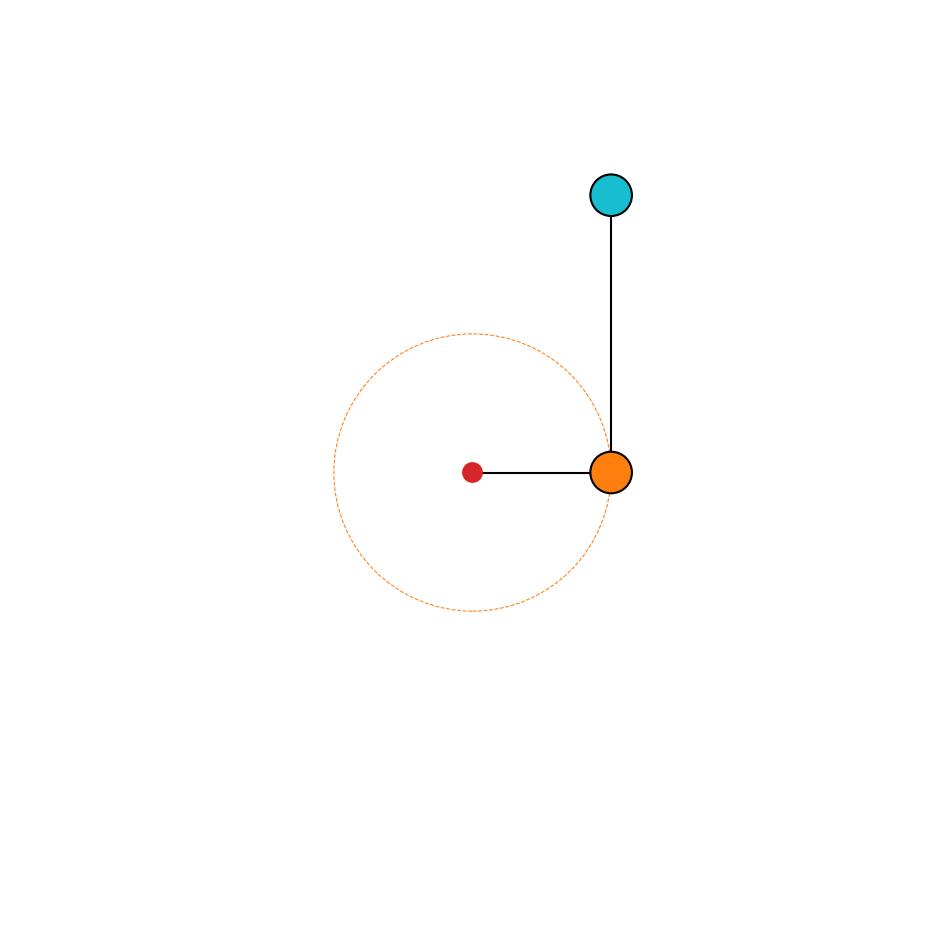

In [44]:
fig, ax, p1, p2, l1, l2, plot2 = plot_animation(data)

In [45]:
from matplotlib import animation
from IPython.display import HTML
import re

In [46]:
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=len(data.t),
    interval=1.e3/fps,
    blit=True,
)

In [47]:
HTML(re.sub('width="\d*" height="\d*"', 'width="100%"', anim.to_html5_video()))

The double pendulum is a [chaotic system](https://en.wikipedia.org/wiki/Chaos_theory). With slightly different initial conditions, the result will differ drastically. We are now going to run the simulation again with slightly different initial conditions and compare the results.

In [48]:
f_theta2 = [0.999, 1.001]

We are going to multiply the initial angle of the second pendulum by $0.999$ and $1.001$ and run the simulation again.

In [49]:
def restart(sim, f_theta2):
    ret = []
    for f in f_theta2:
        sim.Y[:] = Y0
        sim.Y[1] *= f
        sim.update()
        sim.writer.reset()
        sim.t = 0.
        sim.run()
        data = sim.writer.read.all()
        ret.append(data)
    return ret

In [50]:
data_new = restart(sim, f_theta2)

Execution time: 0:00:09
Execution time: 0:00:08


We combine the old and new results in one list and plot the trajectories of the second pendulum.

In [51]:
data_new.insert(0, data)

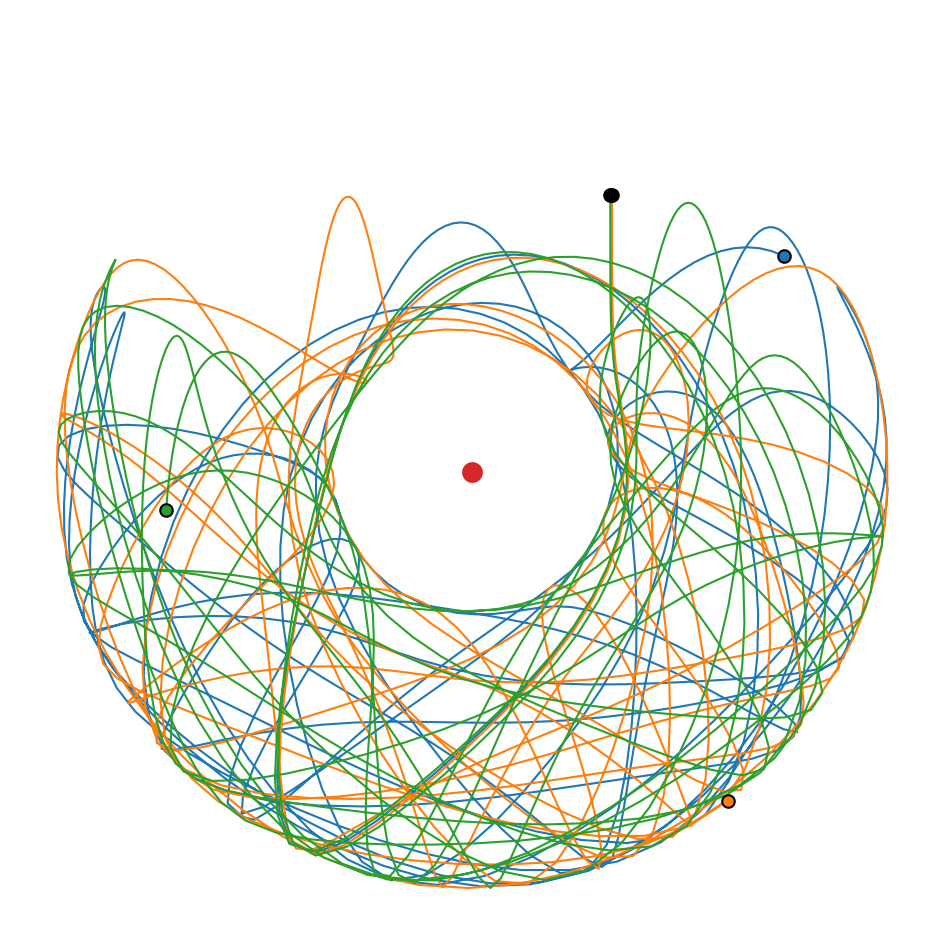

In [52]:
plot_trajectories(data_new)

Although all simulations started at almost the same spot, the final position of the second pendulum differs drastically.